### 环境准备与参数设定

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 基本仿真参数 ---
T = 150.0  # 总仿真时长 (与图1一致)
dt = 0.01  # 时间步长
N = int(T / dt)  # 总步数

# --- 2. 空间离散化参数 ---
L = 4.0  # 空间长度 [-2, 2]
dx = 0.1  # 空间步长
J = int(L / dx) + 1  # 空间网格点数

# --- 3. 神经网络模型参数 ---
# 神经元数量 n=2, 空间维度 q=1 (因为 Ω = {x | x in [-2, 2]})
n = 2

# 系统矩阵 (根据论文例2) [cite: 528, 530, 531]
D = np.diag([0.1, 0.1])

A1 = np.diag([1.0, 1.0])
A2 = np.diag([0.9, 0.9])

W11 = np.array([[2.0, -0.1], [-5.0, 2.8]])
W21 = np.array([[-1.6, -0.1], [-0.3, -2.5]])

W12 = np.array([[0.5, 0.6], [0.4, 0.2]])
W22 = np.array([[0.2, 0.3], [0.4, 0.5]])

B1 = np.array([[-2.0, 1.0], [0.0, -2.0]])
B2 = B1  # B1 = B2


# 激活函数 f(·) = tanh(·) [cite: 532]
def f(z):
    return np.tanh(z)


# 时滞 τ(t) = 1 [cite: 532]
tau = 1.0
tau_steps = int(tau / dt)  # 换算成时间步数

# --- 4. 控制器相关参数 ---
# 执行器故障参数 [cite: 544]
g_tilde_ji = 0.2  # g下界
g_hat_ji = 0.8  # g上界
# 为简单起见，我们可以在仿真中取一个固定值，例如取其中间值
G1 = np.diag([0.5, 0.5])
G2 = np.diag([0.5, 0.5])

# 增益扰动参数 (仿真中可以先忽略或设为0)
# Z1, Z2, H1, H2... [cite: 543]
# Fi(t) = sin(t) [cite: 544]

# 论文中解出的控制器增益 [cite: 546]
K1 = np.array([[95.1945, 4.3730], [-55.3191, 101.1654]])
K2 = np.array([[48.9157, 25.2136], [-36.9121, 78.3478]])


# --- 5. 随机项参数 ---
# σ(t, ζ, ζ_tau) = diag{ζ, ζ_tau} [cite: 533]
# 这是一个简化形式，实际实现时需要根据定义来
# σ_1, σ_2 是其系数，这里我们根据其形式定义函数
def sigma(zeta, zeta_tau):
    # 论文中的定义比较模糊，这里我们先假设一个合理的结构
    # 例如，噪声强度与误差大小成正比
    # 为简化起见，我们先用一个简单的标量系数
    sigma_coeff = 0.1  # 假设一个噪声强度系数
    # 返回一个 (n, J) 的矩阵
    return sigma_coeff * zeta


print("参数设置完成。")

参数设置完成。


### 计算扩散项

In [5]:
def calculate_diffusion(z, D, dx):
    """
    使用有限差分法计算反应扩散项 D * d^2z/dx^2

    参数:
    z (np.array): 当前系统状态, 维度为 (n, J)，n是神经元数量, J是空间点数
    D (np.array): 扩散系数矩阵, 维度为 (n, n)
    dx (float): 空间步长

    返回:
    diffusion_term (np.array): 计算出的扩散项, 维度为 (n, J)
    """
    n, J = z.shape

    # 使用np.roll高效计算邻居节点的值
    # z_right是每个点右边的邻居 (循环边界)
    z_right = np.roll(z, -1, axis=1)
    # z_left是每个点左边的邻居 (循环边界)
    z_left = np.roll(z, 1, axis=1)

    # 计算二阶导数的近似值 (Laplacian)
    laplacian = (z_left - 2 * z + z_right) / (dx**2)

    # 应用狄利克雷边界条件 (两端的值由其邻居决定，但它们自身的变化不应影响内部)
    # 更准确地说，在主循环中，我们将强制z的最左和最右列为0。
    # 这里的计算暂时使用循环边界，在主循环中再强制边界为0。

    # 计算最终的扩散项 D * Laplacian
    # D是(n,n)矩阵, laplacian是(n,J)矩阵, 使用矩阵乘法
    diffusion_term = D @ laplacian

    return diffusion_term


# # 简单的测试
# test_z = np.zeros((n, J))
# test_z[0, 5] = 1.0 # 在某个点给一个扰动
# diffusion = calculate_diffusion(test_z, D, dx)
# print("扩散项计算函数测试完成。")
# print("扰动点周围的扩散效果（部分）:", diffusion[0, 4:7])


### 核心动态函数

In [7]:
def calculate_derivatives(z1, z2, z1_tau, z2_tau, mode):
    """
    计算主从系统在当前状态下的导数（变化率）。

    参数:
    z1, z2 (np.array): 主、从系统当前状态, 维度 (n, J)
    z1_tau, z2_tau (np.array): 主、从系统时滞状态, 维度 (n, J)
    mode (int): 当前系统模式 (1 或 2)

    返回:
    dz1_dt (np.array): 主系统的总变化率（确定性部分）
    dz2_dt (np.array): 从系统的总变化率（确定性部分）
    sigma_term (np.array): 随机项的系数
    """
    # 1. 根据模式选择系统参数
    if mode == 1:
        A, W1, W2, B, K, G = A1, W11, W21, B1, K1, G1
    else:  # mode == 2
        A, W1, W2, B, K, G = A2, W12, W22, B2, K2, G2

    # 2. 计算扩散项 (调用上一步编写的函数)
    diffusion_z1 = calculate_diffusion(z1, D, dx)
    diffusion_z2 = calculate_diffusion(z2, D, dx)

    # 3. 计算激活函数项
    f_z1 = f(z1)
    f_z2 = f(z2)
    f_z1_tau = f(z1_tau)
    f_z2_tau = f(z2_tau)

    # 4. 计算主系统 dz1/dt 的确定性部分
    dz1_dt = diffusion_z1 - A @ z1 + W1 @ f_z1 + W2 @ f_z1_tau

    # 5. 计算从系统 dz2/dt 的控制项
    zeta = z1 + z2
    u = K @ zeta  # 理想控制器输出
    u_f = G @ u  # 经过故障执行器的实际输出
    control_term = B @ u_f

    # 6. 计算从系统 dz2/dt 的确定性部分
    dz2_dt = diffusion_z2 - A @ z2 + W1 @ f_z2 + W2 @ f_z2_tau + control_term

    # 7. 计算随机项的系数
    zeta_tau = z1_tau + z2_tau
    # 根据论文定义 sigma(t, ζ, ζ_tau)，这里我们使用之前定义的简化版
    sigma_term = sigma(zeta, zeta_tau)

    return dz1_dt, dz2_dt, sigma_term


# # 测试函数是否能正常运行
# # 需要先初始化一些状态
# initial_z1 = np.random.randn(n, J)
# initial_z2 = np.random.randn(n, J)
# dz1, dz2, st = calculate_derivatives(initial_z1, initial_z2, initial_z1, initial_z2, 1)
# print("核心动态函数测试完成。")
# print("dz1/dt 维度:", dz1.shape)
# print("dz2/dt 维度:", dz2.shape)


### 模拟半马尔可夫过程

开始仿真...
仿真完成。


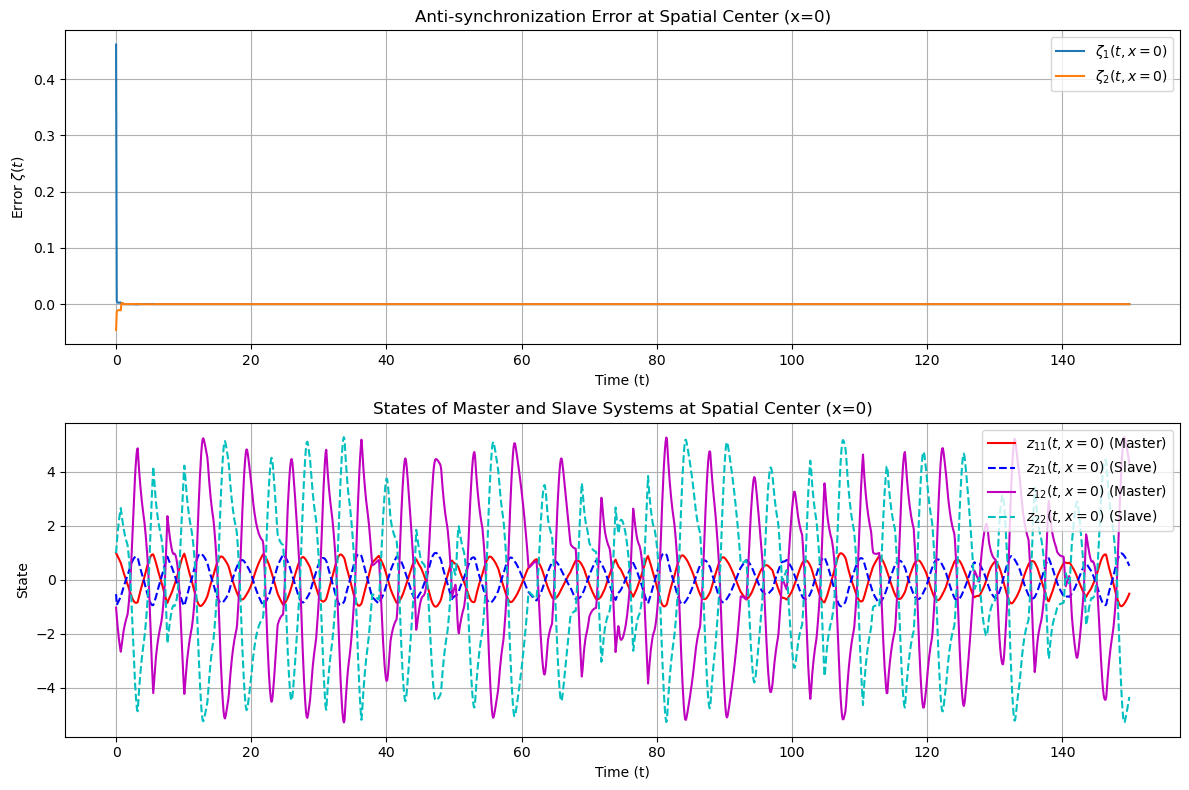

In [8]:
# (将这段代码接在之前步骤的代码后面)

# --- 5. 历史数据初始化 ---
# 需要存储过去tau秒的历史数据以计算时滞项
history_z1 = np.zeros((n, J, tau_steps))
history_z2 = np.zeros((n, J, tau_steps))

# 根据论文设置初始条件 z1(s,x)=[1, -1]T, z2(s,x)=[-1, 2]T
# 我们将这个初始值赋给整个历史区间
history_z1[0, :, :] = 1.0
history_z1[1, :, :] = -1.0
history_z2[0, :, :] = -1.0
history_z2[1, :, :] = 2.0

# 当前状态初始化
z1 = history_z1[:, :, -1].copy()
z2 = history_z2[:, :, -1].copy()

# --- 6. 数据记录与半马尔可夫过程初始化 ---
# 用于存储绘图数据的列表
z1_plot = []
z2_plot = []
zeta_plot = []
time_points = []
mode_plot = []

# 半马尔可夫过程初始化
current_mode = 1
# 论文 Weibull(k, λ) -> numpy: λ * np.random.weibull(k)
# Mode 1: Weibull(2, 2)
time_to_switch = 2.0 * np.random.weibull(2.0)
time_in_mode = 0.0

# --- 7. 主循环 ---
print("开始仿真...")
for k in range(N):
    current_time = k * dt

    # 7.1 更新半马尔可夫模式
    time_in_mode += dt
    if time_in_mode >= time_to_switch:
        # 切换模式
        current_mode = 2 if current_mode == 1 else 1
        # 抽取新的驻留时间
        if current_mode == 1:
            # Mode 1: Weibull(2, 2) -> shape=2, scale=2
            time_to_switch = 2.0 * np.random.weibull(2.0)
        else:
            # Mode 2: Weibull(1, 3) -> paper e2(h)=3h^2*exp(-h^3) is Weibull(k=3, λ=1)
            time_to_switch = 1.0 * np.random.weibull(3.0)
        # 重置计时器
        time_in_mode = 0.0

    # 7.2 获取时滞状态
    # history数组中，-1是上一个时刻，-tau_steps是tau秒前的时刻
    z1_tau = history_z1[:, :, 0]
    z2_tau = history_z2[:, :, 0]

    # 7.3 调用核心函数计算变化率
    dz1_dt, dz2_dt, sigma_term = calculate_derivatives(
        z1, z2, z1_tau, z2_tau, current_mode
    )

    # 7.4 计算随机项
    dW = np.sqrt(dt) * np.random.randn(n, J)

    # 7.5 更新状态 (欧拉-丸山法)
    z1_new = z1 + dt * dz1_dt
    # 只有从系统有噪声
    z2_new = z2 + dt * dz2_dt + sigma_term * dW

    # 7.6 强制施加边界条件
    z1_new[:, 0] = 0
    z1_new[:, -1] = 0
    z2_new[:, 0] = 0
    z2_new[:, -1] = 0

    # 7.7 更新状态变量
    z1 = z1_new
    z2 = z2_new

    # 7.8 更新历史数据
    history_z1 = np.roll(history_z1, -1, axis=2)
    history_z2 = np.roll(history_z2, -1, axis=2)
    history_z1[:, :, -1] = z1
    history_z2[:, :, -1] = z2

    # 7.9 记录绘图数据 (每隔一段时间记录一次，避免数据量过大)
    if k % 10 == 0:
        # 记录空间中心点 x=0 的状态
        center_point_idx = J // 2
        zeta = z1 + z2
        z1_plot.append(z1[:, center_point_idx])
        z2_plot.append(z2[:, center_point_idx])
        zeta_plot.append(zeta[:, center_point_idx])
        time_points.append(current_time)
        mode_plot.append(current_mode)

print("仿真完成。")

# --- 8. 绘图 ---
z1_plot = np.array(z1_plot)
z2_plot = np.array(z2_plot)
zeta_plot = np.array(zeta_plot)

plt.figure(figsize=(12, 8))

# 图1: 反同步误差 zeta(t)
plt.subplot(2, 1, 1)
plt.plot(time_points, zeta_plot[:, 0], label="$\\zeta_1(t, x=0)$")
plt.plot(time_points, zeta_plot[:, 1], label="$\\zeta_2(t, x=0)$")
plt.title("Anti-synchronization Error at Spatial Center (x=0)")
plt.xlabel("Time (t)")
plt.ylabel("Error $\\zeta(t)$")
plt.grid(True)
plt.legend()

# 图2: 主从系统状态 z1(t), z2(t)
plt.subplot(2, 1, 2)
plt.plot(time_points, z1_plot[:, 0], "r-", label="$z_{11}(t, x=0)$ (Master)")
plt.plot(time_points, z2_plot[:, 0], "b--", label="$z_{21}(t, x=0)$ (Slave)")
plt.plot(time_points, z1_plot[:, 1], "m-", label="$z_{12}(t, x=0)$ (Master)")
plt.plot(time_points, z2_plot[:, 1], "c--", label="$z_{22}(t, x=0)$ (Slave)")
plt.title("States of Master and Slave Systems at Spatial Center (x=0)")
plt.xlabel("Time (t)")
plt.ylabel("State")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
